In [12]:
import pandas as pd
from nltk.corpus import stopwords
import os, sys, email,re
#Cluster with KMeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import matplotlib.pyplot as plt

from spacy.lang.en import English
import spacy
nlp = spacy.load('en_core_web_lg')

In [13]:
pd.options.mode.chained_assignment = None

chunk = pd.read_csv('/Users/schavali/Downloads/emails.csv', chunksize=10000)
data = next(chunk)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
file       10000 non-null object
message    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB



## Some Helper Functions from Kaggle community


In [14]:
def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message=message.lower()
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = " ".join(message_words)
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result



In [16]:
data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['subject'] = get_row(data.message, 4)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

data.subject = data.subject.str.replace('Subject: ', '')

del data['file']
del data['message']
## Filtering out all the forwarded or reply emails 
choice=np.array(["---- forwarded" not in "".join(i) for i in data.text])
choice2=np.array(["re:" not in "".join(i) for i in data.subject])

data=data[(choice & choice2)]
data = data[['text']]

print(data.head())



                                                text
0                            here is our forecast   
1   traveling to have a business meeting takes th...
2                     test successful.  way to go!!!
3   randy,   can you send me a schedule of the sa...
4                let's shoot for tuesday at 11:45.  


In [17]:
print("Original dataset size {}".format(len(choice)))
print("Current Dataset after initial filtering {}".format(len(data)))

Original dataset size 10000
Current Dataset after initial filtering 8161


In [34]:
# https://www.kaggle.com/donaldtfung/e-mail-categorization
# https://www.regular-expressions.info/email.html for email regex
def clean_text_through_regex(message):
#     print(row)
    tokens = []
    try:
        for token in message.split():
            token = token.lower()
            token = re.sub("\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b"," ",token)
            token=re.sub('\S+@\S+'," ",token)
            token= re.sub("[0-9]{10,}"," ",token)
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return " ".join(tokens)


In [35]:
#verifying clean_text method
print(clean_text_through_regex(" this is the message #@#%%%% (*(!.)) "))
print(clean_text_through_regex("kbkb@email.com"))
print(clean_text_through_regex("1231241241321 the number should be stripped"))

this is the message   (*(!.))
 
  the number should be stripped


## Rules Considered for Clustering
 - if any text contains '''verb|adverb + PRON* + verb* '''
     example: can you send me a schedule of the salary and level of everyone in the
 - anything text which ends with question mark
     example : Will you be able to complete it today?
 - anything which has time entity within sentence
     example : let's shoot for tuesday at 11:45
 - added anything which has text - asap, call me , as soon as possible

     
 ``` Here we are less worried about falsely classifying sentences as actionable item. We use the above rules trying to fit as many actionable cases as possible ```

In [36]:
import re
pattern1 = re.compile(".*(can|will|would|please){1}.*(you|her|him).*(send|do|complete|finish|email|write|update|rentroll)*(today|eod|tomorrow|evening)*.*|.*\?")
pattern2=re.compile("asap|as soon as possible")
pattern3=re.compile("call me")
patterns=[pattern1,pattern2,pattern3]
def match_patterns(text):
    for p in patterns:
        if p.match(text):
            return True

In [67]:


def is_future_event(text):
    spacy_doc=nlp(text)
    for ent in spacy_doc.ents:
        if "TIME" in ent.label_:
            return True

## This method tokenizes body within email to sentences and find actionable items, once done we create  a dataframe 
## which contains only sentence information and the class it is clustered to. 
def prepare_sentences_df():
    sentences_list=[]
    class_list=[]
    order_in_mail=[]
    mail_index=[]
    for row,value in enumerate(data.text):
        sentences=value.split(".")
        for i,v in enumerate(sentences):
            if len(v.split())>=5: #only consider sentences longer than 4 words
                sen=clean_text_through_regex(v)
                sentences_list.append(sen)
                order_in_mail.append(i)
                mail_index.append(row)
                if(match_patterns(sen) or is_future_event(v)):
                    class_list.append(True)
                else:
                    class_list.append(False)
    return pd.DataFrame({"sentence":sentences_list,"mail_index":mail_index,"order_in_mail":order_in_mail,"actionable_item":class_list})    
    
sentence_class_df=prepare_sentences_df()

In [53]:
sentence_class_df=sentence_class_df.drop_duplicates(subset='sentence',keep='first')
sentence_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52158 entries, 0 to 97364
Data columns (total 4 columns):
sentence           52158 non-null object
mail_index         52158 non-null int64
order_in_mail      52158 non-null int64
actionable_item    52158 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 1.6+ MB


##  Based on the above clustering rules, the distribution is fairly biased which is evident below

In [69]:
sentence_class_df.actionable_item.value_counts()

False    80511
True     16854
Name: actionable_item, dtype: int64

In [68]:
sentence_class_df.to_csv("./actionable_items_by_rules.csv")

### Now that we have some rule based clustering done , lets see if clustering  using machine learning  would help us in our actionable_items clustering. 

 - We would do a Kmeans clustering ,
     . KMeans is a hard clustering technique, I am not using GMM or LDA as they assign mixture of topics into one cluster

In [64]:
## Lemmatize
def lemmatize(dataframe,attribute):
    for i,v in enumerate(dataframe[attribute]):
        text=clean_text_through_regex(v)
        dc=nlp(text)
        dataframe.at[i,attribute]=" ".join([d.lemma_.lower().strip() if d.lemma_ != "-PRON-" else d.lower_ for d in dc])

    dataframe.head()
    
# lemmatize(data.text)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,ENGLISH_STOP_WORDS

stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient','na','ou','cn','enron','zdnet'])

vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words=stopwords)
tfidf_matrix = vectorizer.fit_transform(data.text.values)
features=vectorizer.get_feature_names()
# print(data.text.values)

### We now will find out what is the best size of k by using elbow method visualizer


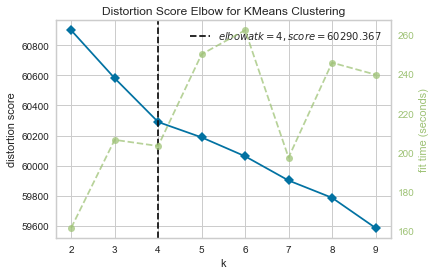

In [44]:

kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)
y_kmeans = kmeans.fit_predict(tfidf_matrix)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(tfidf_matrix)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### by above visualization we see that the best k is 4

The below two blocks are taken from  :https://github.com/anthdm/ml-email-clustering

In [45]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [46]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [47]:
kmeans = KMeans(n_clusters=4, init="k-means++").fit(tfidf_matrix)
y_kmeans = kmeans.fit_predict(tfidf_matrix)



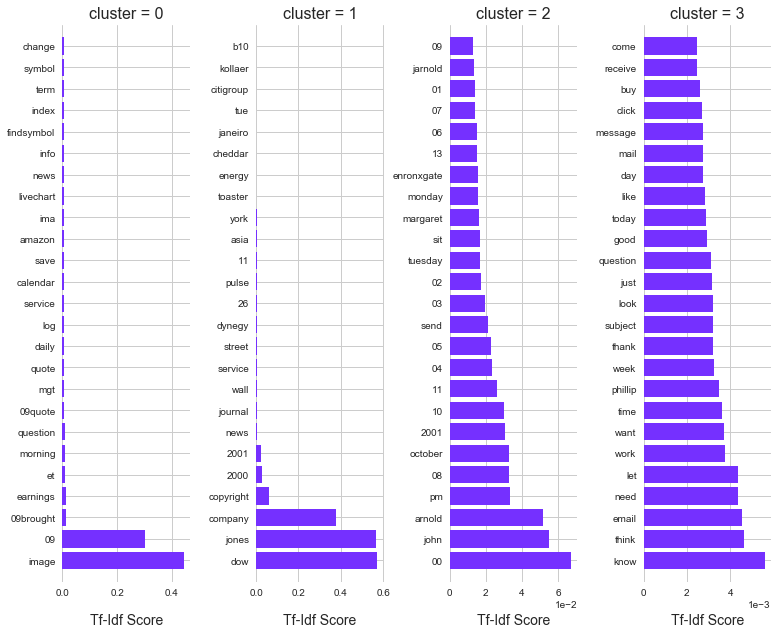

In [48]:
plot_tfidf_classfeats_h(top_feats_per_cluster(tfidf_matrix, y_kmeans, features, 0.3, 25))

### K-Means didn't help a lot in finding out which emails contain actionable_items,  nevertheless cluster 3 has some interesting words which we can further investigate to find some more actionable_items

### I have manually verified the clustered data and corrected some labels .

#### Collated the action_item sentences provided with non_action_item I have created with the rules.
    - There are a total of 1250 sentences in the action_item sentences which are provided
    - From the rules we see that roughly 16% of the sentences were action_items and rest were non action 
    - Following the same distribution I am picking about 5000 sentences of the non_action_item class , this csv would be used for classification task
    
